In [2]:
import numpy as np
import albumentations as albu
import json
import cv2
from datetime import datetime

import sys
sys.path.append('../preprocess/data_loader')
import matplotlib.pyplot as plt
from data_loader import DataLoader
import torch
from datasets import Dataset, DatasetDict, Features, Value, Image, Sequence, ClassLabel
from PIL import ImageDraw
from PIL import Image as ImagePil
from transformers import AutoModelForObjectDetection, DetrForObjectDetection, DeformableDetrForObjectDetection
from transformers import DeformableDetrImageProcessor, DetrImageProcessor, AutoImageProcessor
from transformers import DetrConfig, TrainingArguments, Trainer

# For evaluate
import evaluate
from tqdm import tqdm
import torchvision
import os

2023-05-27 09:46:02.622919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Detectron2 not imported


In [3]:
#CBIS = "/workspace/data/Mammographies/CBIS-DDSM"
#MIAS = "/workspace/data/Mammographies/MIAS"
#INBREAST = "/workspace/data/Mammographies/INBreast"

#loader = DataLoader(INBREAST, MIAS, CBIS)
loader = DataLoader()

features = Features({'image_id': Value(dtype='int64', id=None),
                     'image': Image(decode=True, id=None),
                     'width': Value(dtype='int32', id=None),
                     'height': Value(dtype='int32', id=None),
                     'objects': Sequence(feature={'id': Value(dtype='int64', id=None),
                                                  'area': Value(dtype='int64', id=None),
                                                  'bbox': Sequence(feature=Value(dtype='float32', id=None),
                                                                   length=4,
                                                                   id=None),
                                                  'category': ClassLabel(names=["Abnormality"], id=None)
                                                  },
                                         length=-1,
                                         id=None)
                     })


dataset = Dataset.from_generator(loader.object_detection_generator(target_library="hugging_face"),
                                 features=features,
                                 cache_dir="./dataset_detection_cache",
                                 )

Generating train split: 0 examples [00:00, ? examples/s]

Dataset generator downloaded and prepared to /tf/code/vit-object-detection/dataset_detection_cache/generator/default-a2d55375bf2af2c7/0.0.0. Subsequent calls will reuse this data.


In [4]:
dataset=dataset.shuffle()

In [5]:
# 90% train, 10% test + validation
train_testvalid = dataset.train_test_split(test_size=0.3)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 2441
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 524
    })
    valid: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 523
    })
})

In [6]:
dataset["train"].features

{'image_id': Value(dtype='int64', id=None),
 'image': Image(decode=True, id=None),
 'width': Value(dtype='int32', id=None),
 'height': Value(dtype='int32', id=None),
 'objects': Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['Abnormality'], id=None)}, length=-1, id=None)}

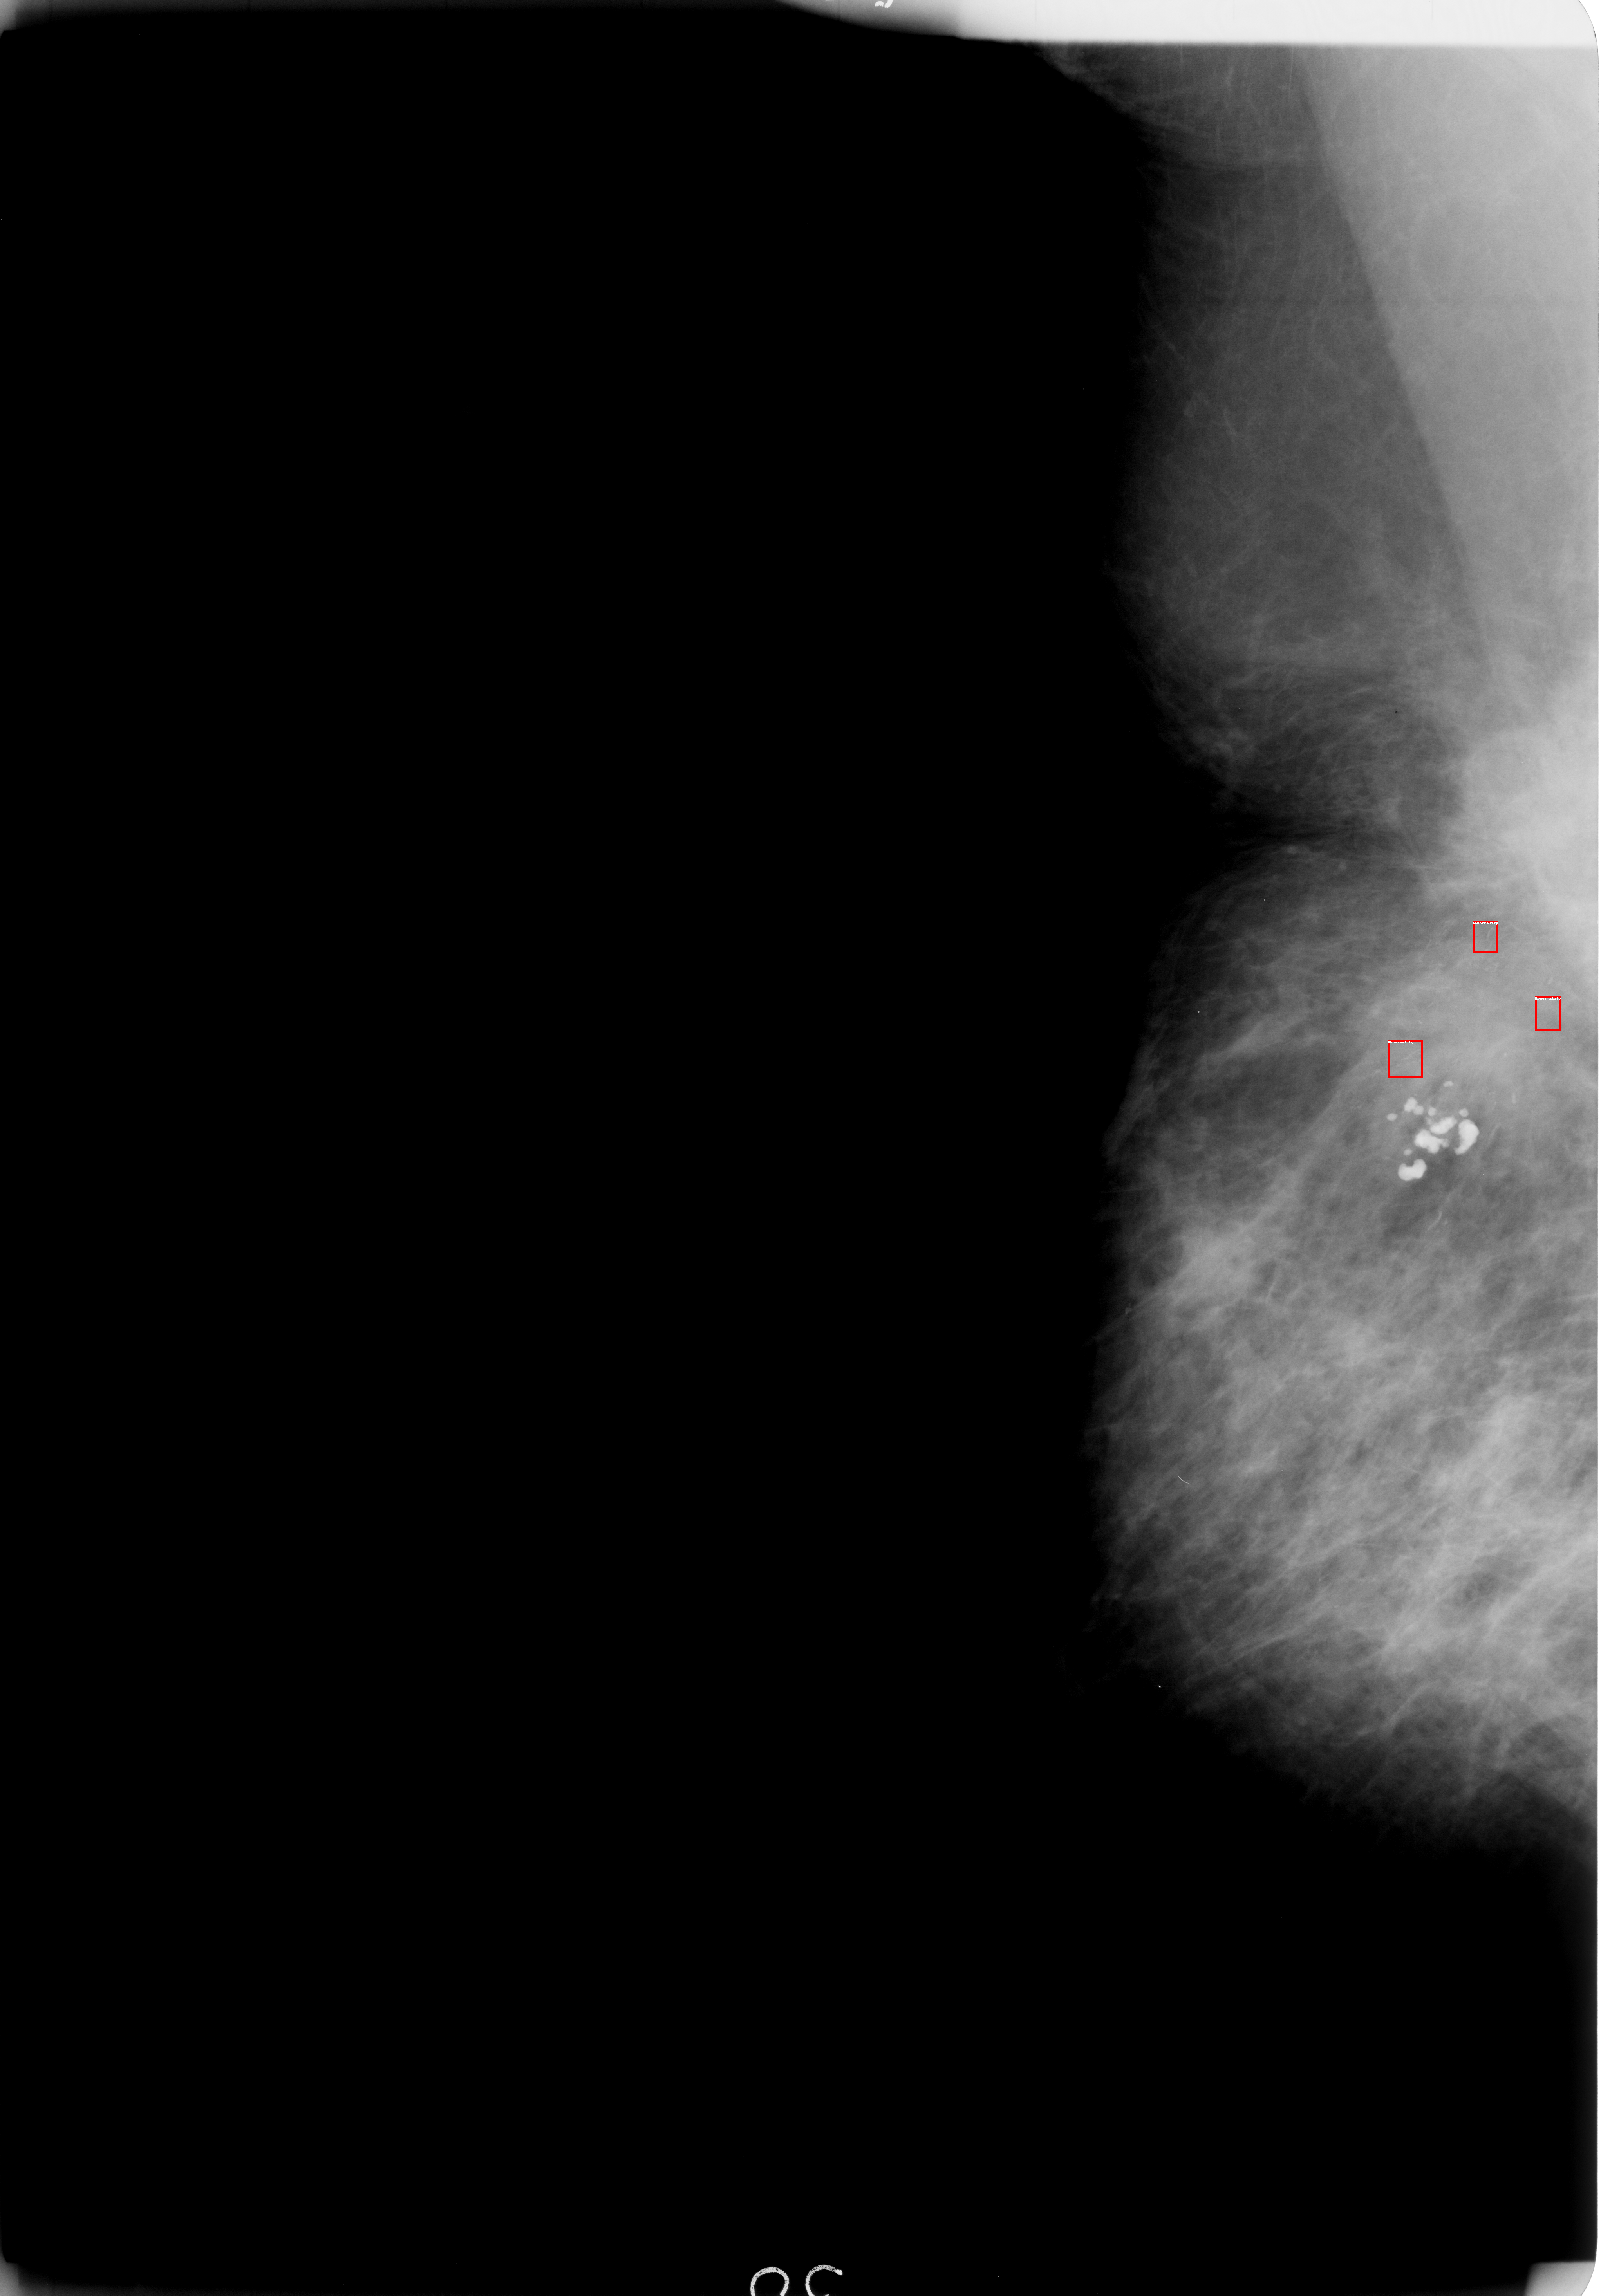

In [7]:
image_id=0
image = dataset["train"][image_id]["image"].convert("RGB")
annotations = dataset["train"][image_id]["objects"]
draw = ImageDraw.Draw(image)

categories = dataset["train"].features["objects"].feature["category"].names

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=5)
    draw.text((x, y), id2label[class_idx], fill="white")

image

In [8]:
# Load large models https://huggingface.co/docs/transformers/main_classes/model#large-model-loading

#checkpoint = "SenseTime/deformable-detr"
checkpoint = "facebook/detr-resnet-50"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [9]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = loader.transform(image, objects["bbox"], objects["category"])

        area.append([w*h for _,_,w,h in out["bboxes"]])
        #area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])
        

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]
    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [10]:
train_ds = dataset["train"].with_transform(transform_aug_ann)
val_ds = dataset["valid"].with_transform(transform_aug_ann)

In [11]:
train_ds[0]

{'pixel_values': tensor([[[-1.9295, -1.9295, -1.9295,  ..., -1.9295, -1.9295, -1.9295],
          [-1.9295, -1.9295, -1.9295,  ..., -1.9295, -1.9295, -1.9295],
          [-1.9295, -1.9295, -1.9295,  ..., -1.9295, -1.9295, -1.9295],
          ...,
          [-1.9295, -1.9295, -1.9295,  ..., -1.9295, -1.9295, -1.9295],
          [-1.9295, -1.9295, -1.9295,  ..., -1.9295, -1.9295, -1.9295],
          [-1.9295, -1.9295, -1.9295,  ..., -1.9295, -1.9295, -1.9295]],
 
         [[-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431],
          [-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431],
          [-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431],
          ...,
          [-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431],
          [-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431],
          [-1.8431, -1.8431, -1.8431,  ..., -1.8431, -1.8431, -1.8431]],
 
         [[-1.6127, -1.6127, -1.6127,  ..., -1.6127, -1.6127, -1.6127],
          [-

# Search Hyperparameters

In [11]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
    #encoding = batch
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [12]:
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True),
    }

def model_init(trial):
  return AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

In [13]:
training_args = TrainingArguments(
    output_dir="hyper_params",
    per_device_train_batch_size=2,
    num_train_epochs=2,
    fp16=False,
    logging_steps=50,
    save_strategy="no",
    remove_unused_columns=False,
    push_to_hub=False,
)

trainer = Trainer(
    model=None,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    model_init=model_init,
)

best_trial = trainer.hyperparameter_search(
    direction="minimize", #default metric is loss
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=10,
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2023-05-20 07:23:15,151] A new study created in memory with name: no-name-9ef02144-f0cc-49bc-96b4-a8daf5f36cc5
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because t

[I 2023-05-20 08:01:08,486] Trial 0 finished with value: 2.8190128803253174 and parameters: {'learning_rate': 4.404452635496227e-05, 'weight_decay': 2.0658673890240608e-05}. Best is trial 0 with value: 2.8190128803253174.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2023-05-20 08:40:16,219] Trial 1 finished with value: 2.443845748901367 and parameters: {'learning_rate': 9.956156873685714e-06, 'weight_decay': 3.828905136486675e-06}. Best is trial 1 with value: 2.443845748901367.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2023-05-20 09:20:17,944] Trial 2 finished with value: 2.8007030487060547 and parameters: {'learning_rate': 6.526212397484183e-05, 'weight_decay': 3.417057802711366e-06}. Best is trial 1 with value: 2.443845748901367.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2023-05-20 09:59:29,253] Trial 3 finished with value: 2.5224900245666504 and parameters: {'learning_rate': 3.389286164328232e-05, 'weight_decay': 8.175092299283526e-05}. Best is trial 1 with value: 2.443845748901367.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2023-05-20 10:38:29,685] Trial 4 finished with value: 3.139065742492676 and parameters: {'learning_rate': 2.104177588215571e-06, 'weight_decay': 6.062777263572884e-05}. Best is trial 1 with value: 2.443845748901367.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2023-05-20 11:18:10,178] Trial 5 finished with value: 3.2117819786071777 and parameters: {'learning_rate': 1.7204943966134828e-06, 'weight_decay': 2.270734817085017e-06}. Best is trial 1 with value: 2.443845748901367.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2023-05-20 11:57:44,842] Trial 6 finished with value: 2.641432523727417 and parameters: {'learning_rate': 3.737043105286216e-05, 'weight_decay': 3.7014179295939687e-06}. Best is trial 1 with value: 2.443845748901367.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2023-05-20 12:37:52,995] Trial 7 finished with value: 2.4571752548217773 and parameters: {'learning_rate': 8.246011504742516e-06, 'weight_decay': 4.953872304040292e-05}. Best is trial 1 with value: 2.443845748901367.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2023-05-20 13:16:33,926] Trial 8 finished with value: 3.1072232723236084 and parameters: {'learning_rate': 2.3668095538031894e-06, 'weight_decay': 4.2214155360466014e-05}. Best is trial 1 with value: 2.443845748901367.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[I 2023-05-20 13:55:26,147] Trial 9 finished with value: 3.249668836593628 and parameters: {'learning_rate': 2.3943944478297727e-06, 'weight_decay': 3.7162902717640406e-05}. Best is trial 1 with value: 2.443845748901367.


In [14]:
"""Parameters:
        run_id (:obj:`str`):
            The id of the best run (if models were saved, the corresponding checkpoint will be in the folder ending
            with run-{run_id}).
        objective (:obj:`float`):
            The objective that was obtained for this run.
        hyperparameters (:obj:`Dict[str, Any]`):
            The hyperparameters picked to get this run.
"""
best_trial

BestRun(run_id='1', objective=2.443845748901367, hyperparameters={'learning_rate': 9.956156873685714e-06, 'weight_decay': 3.828905136486675e-06}, run_summary=None)

# Training

In [15]:
model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
training_args = TrainingArguments(
    output_dir=f'/workspace/test_vit_{checkpoint.replace("/","_")}_{datetime.now().strftime("%d%m%Y_%H%M%S")}',
    per_device_train_batch_size=2,
    num_train_epochs=10,
    fp16=False,
    logging_steps=50,
    learning_rate=best_trial.hyperparameters["learning_rate"],
    weight_decay=best_trial.hyperparameters["weight_decay"],
    save_total_limit=4,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    save_strategy="epoch",
    evaluation_strategy="epoch"
    
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor
)

trainer.train()

TrainOutput(global_step=12210, training_loss=2.0512670706765364, metrics={'train_runtime': 12833.7184, 'train_samples_per_second': 1.902, 'train_steps_per_second': 0.951, 'total_flos': 1.16653542494976e+19, 'train_loss': 2.0512670706765364, 'epoch': 10.0})

In [17]:
model_name=f'./vit__{checkpoint.replace("/","_")}_{datetime.now().strftime("%d%m%Y_%H%M%S")}'
model.save_pretrained(model_name)

# Inference

In [48]:
if 'model_name' not in globals():
    model = AutoModelForObjectDetection.from_pretrained(
        "./vit__facebook_detr-resnet-50_20052023_172920",
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )

model_cpu = model.to("cpu")

test_sample = dataset["test"][5]

processed_sample = loader.transform(np.array(test_sample["image"].convert("RGB")),
                       test_sample["objects"]["bbox"],
                       test_sample["objects"]["category"])
image = ImagePil.fromarray(processed_sample["image"])

inputs = image_processor(images=image, return_tensors="pt")
outputs = model_cpu(**inputs)

In [49]:
# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.7
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected Abnormality with confidence 0.574 at location [447.95, 733.54, 541.53, 828.41]
Detected Abnormality with confidence 0.561 at location [249.88, 498.44, 355.52, 606.69]
Detected Abnormality with confidence 0.509 at location [736.14, 906.61, 817.74, 984.58]
Detected Abnormality with confidence 0.536 at location [400.36, 428.8, 508.91, 537.39]
Detected Abnormality with confidence 0.649 at location [747.89, 650.4, 849.15, 759.2]
Detected Abnormality with confidence 0.565 at location [292.31, 671.08, 391.49, 751.62]


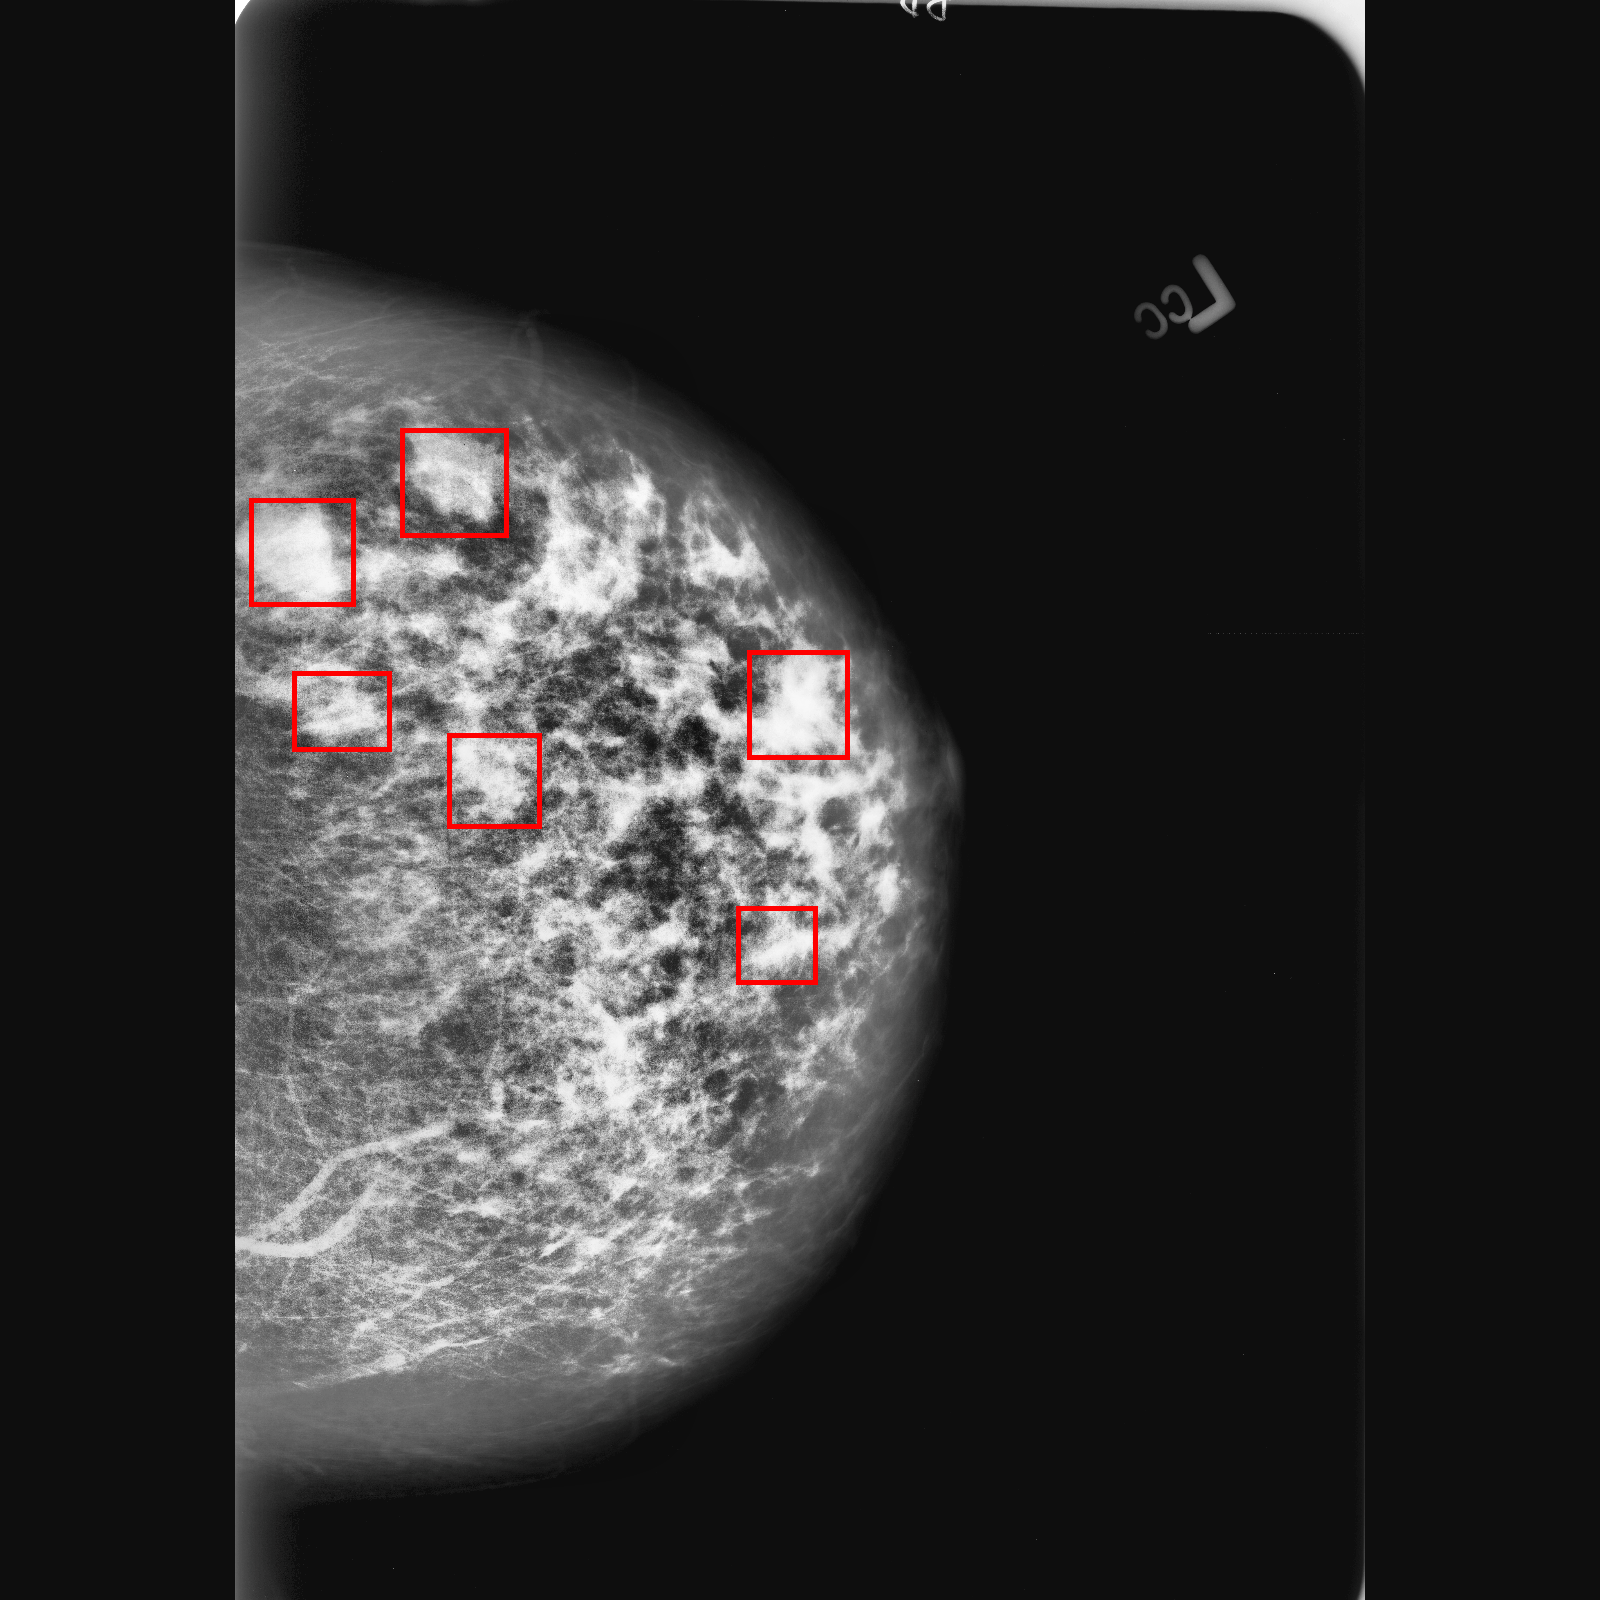

In [50]:
draw = ImageDraw.Draw(image)


for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    x, y, w, h = tuple(box)
    x= float(x)
    y= float(y)
    w= float(w)
    h= float(h)
    draw.rectangle((x, y, w, h), outline="red", width=5)

image

# Evaluate

In [21]:
# format annotations the same as for training, no need for data augmentation
def val_formatted_anns(image_id, objects):
    annotations = []
    for i in range(0, len(objects["id"])):
        new_ann = {
            "id": objects["id"][i],
            "category_id": objects["category"][i],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][i],
            "bbox": objects["bbox"][i],
        }
        annotations.append(new_ann)

    return annotations


# Save images and annotations into the files torchvision.datasets.CocoDetection expects
def save_cppe5_annotation_file_images(cppe5):
    output_json = {}
    path_output_cppe5 = f"{os.getcwd()}/evaluate_files/"

    if not os.path.exists(path_output_cppe5):
        os.makedirs(path_output_cppe5)

    path_anno = os.path.join(path_output_cppe5, "evaluate.json")
    categories_json = [{"supercategory": "none", "id": id, "name": id2label[id]} for id in id2label]
    output_json["images"] = []
    output_json["annotations"] = []
    
    total=len(cppe5)
    for i, example in enumerate(cppe5):
        path_img = os.path.join(path_output_cppe5, f"{example['image_id']}.png")
        # Apply CLAHE and default transformations
        out = loader.transform(np.array(example["image"]), example["objects"]["bbox"], example["objects"]["category"])
        
        cv2.imwrite(path_img,out["image"])
        example["objects"]["bbox"]=out["bboxes"]
        ann = val_formatted_anns(example["image_id"], example["objects"])
        output_json["images"].append(
            {
                "id": example["image_id"],
                "width": out["image"].shape[0],
                "height": out["image"].shape[1],
                "file_name": f"{example['image_id']}.png",
            }
        )
        output_json["annotations"].extend(ann)
    output_json["categories"] = categories_json

    with open(path_anno, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    return path_output_cppe5, path_anno

In [23]:
path_output_cppe5, path_anno = save_cppe5_annotation_file_images(dataset["test"])

In [24]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, ann_file):
        super().__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target: converting target to DETR format,
        # resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {"image_id": image_id, "annotations": target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()  # remove batch dimension
        target = encoding["labels"][0]  # remove batch dimension

        return {"pixel_values": pixel_values, "labels": target}


im_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [25]:
test_ds_coco_format = CocoDetection(path_output_cppe5, im_processor, path_anno)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [26]:
module = evaluate.load("ybelkada/cocoevaluate", coco=test_ds_coco_format.coco)
val_dataloader = torch.utils.data.DataLoader(
    test_ds_coco_format, batch_size=4, shuffle=False, collate_fn=collate_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]  # these are in DETR format, resized + normalized

        # forward pass
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
        results = im_processor.post_process(outputs, orig_target_sizes)  # convert outputs of model to COCO api

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()
print(results)

100%|██████████| 131/131 [07:33<00:00,  3.46s/it]


Accumulating evaluation results...
DONE (t=0.35s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.039
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.025
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.057
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.043
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la